In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time
from tqdm import tqdm

import gym_Snake

from keras import layers,Model,optimizers,losses
import tensorflow as tf

## Environment

In [3]:
env = gym.make('Snake-v0', 
               player='computer', 
               shape='Normal', 
               state_mode='matrix', 
               reward_mode = 'extended', 
               width=10, 
               height=10, 
               solid_border=True)
print(env.observation_space)
print(env.action_space)

Discrete(100)
Discrete(3)


### Creating Network

In [6]:
#input_shape = (obs.shape)

input_matrix = (15,15,1,)

number_of_action = 3


# Classic 3L CNN into 2 dense output layer serving as Deep Q Network
# 3 conv2D layer into maxpooling into flatten into 2 denses layers

# Can remove the max pooling maybe, and change last layer softmax -> linear if simpler needed
# Archi based on different readings // assumed similar difficulties as MNIST personal implementation

def create_Q_network():

    inputs = layers.Input(shape=input_matrix)

    # CNN layers
    layer1 = layers.Conv2D(32, kernel_size=(3, 3),activation="relu")(inputs)
    layer2 = layers.Conv2D(64, kernel_size=(3, 3),activation="relu")(layer1)
    layer3 = layers.Conv2D(128, kernel_size=(3, 3),activation="relu")(layer2)

    # Max Pooling which can probably be removed 
    #layer4 = layers.MaxPooling2D(pool_size=(2,2))(layer3)

    # Flatten 
    layer5 = layers.Flatten()(layer3)

    # Dense layer to predict the action
    layer6 = layers.Dense(512,activation="relu")(layer5)
    action = layers.Dense(number_of_action,activation="softmax")(layer6)

    return Model(inputs=inputs,outputs=action)



In [4]:
#input_shape = (obs.shape)

input_matrix = (20,20,1,)

number_of_action = 3


# Classic 3L CNN into 2 dense output layer serving as Deep Q Network
# 3 conv2D layer into maxpooling into flatten into 2 denses layers

# Can remove the max pooling maybe, and change last layer softmax -> linear if simpler needed
# Archi based on different readings // assumed similar difficulties as MNIST personal implementation

def create_small_Q_network():

    inputs = layers.Input(shape=input_matrix)

    # CNN layers
    layer1 = layers.Conv2D(32, kernel_size=(3, 3),activation="relu")(inputs)
    layer2 = layers.Conv2D(64, kernel_size=(3, 3),activation="relu")(layer1)
    #layer3 = layers.Conv2D(128, kernel_size=(3, 3),activation="relu")(layer2)

    # Max Pooling which can probably be removed 
    #layer4 = layers.MaxPooling2D(pool_size=(2,2))(layer3)

    # Flatten 
    layer5 = layers.Flatten()(layer2)

    # Dense layer to predict the action
    layer6 = layers.Dense(128,activation="relu")(layer5)
    action = layers.Dense(number_of_action,activation="softmax")(layer6)

    return Model(inputs=inputs,outputs=action)


Cf Deep Q learning paper (and some other lectures)

We're using two networks, one to predict the Q-values, and the second is used as target for the prediction

In [5]:
model = create_small_Q_network()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 20, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
___________________________________________________

2022-05-18 09:50:50.342971: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-18 09:50:50.343387: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 09:50:50.346574: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model_target = create_small_Q_network()

model_target.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 20, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
_________________________________________________

## Training

cf https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc
and https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
def play_epoch(env,epsilon,action_history,state_history,state_next_history,done_history,rewards_history, discount = 0.99,
max_steps_per_epoch = 5000,epsilon_min = 0.1,epsilon_max = 1.0,epsilon_random_frames = 20000,epsilon_greedy_frames = 100000.0,
render = False):

    state = env.reset()
    episode_reward = 0

    epsilon_interval = (epsilon_max - epsilon_min)
    
    done = False
    step_counter = 0

    random_action_counter = 0

    #################################
    ## Change to modify the model training
    
    # How many frame to recover from the replay buffer
    batch_size = 32
    # Train the model after 4 actions
    update_Q_network = 4
    # How often to update the target network
    update_target_network = 10000
    # Replay buffer size
    max_memory_length = 1000000

    while not done and step_counter < max_steps_per_epoch:
        
        step_counter += 1
        
        ###############################
        # Show
        
        if render: env.render()

        ###############################
        # Select Action

        # Use epsilon greedy for exploration, 
        # also in the beginning for "epsilon_random_frames" always random
        if step_counter < epsilon_random_frames or epsilon > random.random():
            # Take random action
            action = np.random.choice(number_of_action)
            random_action_counter += 1
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        ###############################
        # Epsilon decay

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        ###############################
        # Act in the env

        state_next, reward, done, _ = env.step(action)

        ###############################
        # Store reward for that run

        episode_reward += reward    

        ###############################
        # Slow render
        if render: time.sleep(0.5)

        ###############################
        # Save actions and states in replay buffer
        
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        ###############################
        # Update the Q-Network

        # Only once every 4 frames (good tradeoff between speed and efficiency of training)
        # and only when the buffer is at least 32 (the size of the batch)
        
        # Update every fourth frame and once batch size is over 32
        if step_counter % update_Q_network == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Sample from replay buffer
            action_sample = [action_history[i] for i in indices]
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + discount * tf.reduce_max(future_rewards, axis=1)

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, number_of_action)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        ###############################
        # Update the target-Network

        if step_counter % update_target_network == 0:
            
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())

        ###############################
        # Delete the 10'000 oldest replays from buffer history when bigger than allowed 

        if len(done_history) > max_memory_length:
            
            del action_history[:10000]
            del state_history[:10000]
            del state_next_history[:10000]
            del rewards_history[:10000]
            del done_history[:10000]

    return episode_reward,epsilon,random_action_counter

In [13]:
epsilon = 1.0  # Epsilon greedy parameter

# improves training time
optimizer = optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []

episode_reward_history = []
episode_epsilon_history = []
episode_random_action_history = []
# Using huber loss for stability
loss_function = losses.Huber()

# number of epoch
#nb_iterations = 50000
nb_iterations = 15000
#nb_iterations = 70

for i in tqdm(range(nb_iterations)):

    r_episode,epsilon,random_action = play_epoch(env=env,epsilon=epsilon,action_history=action_history,state_history=state_history,state_next_history=state_next_history,done_history=done_history,rewards_history=rewards_history)
    episode_reward_history.append(r_episode)
    episode_epsilon_history.append(epsilon)
    episode_random_action_history.append(random_action)

model.save("../../../Tests/networks/small_q_network")
model_target.save("../../../Tests/networks/small_target_network")


  0%|          | 0/15000 [00:00<?, ?it/s]2022-05-17 17:10:05.023524: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-17 17:10:05.026563: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3792010000 Hz
100%|██████████| 15000/15000 [5:17:07<00:00,  1.27s/it]  
2022-05-17 22:27:12.353831: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../../../Tests/networks/small_q_network/assets
INFO:tensorflow:Assets written to: ../../../Tests/networks/small_target_network/assets


### Visualize results

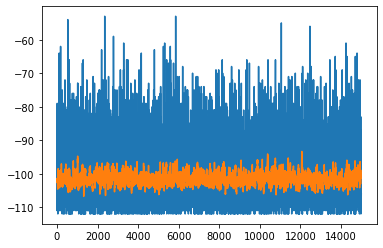

In [14]:
N = 20
plt.plot(range(len(episode_reward_history)), episode_reward_history)
plt.plot(np.convolve(np.array(episode_reward_history), np.ones(N)/N, mode='valid'))

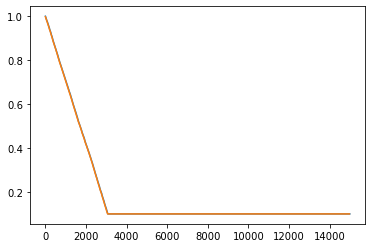

In [15]:
N = 20
plt.plot(range(len(episode_epsilon_history)), episode_epsilon_history)
plt.plot(np.convolve(np.array(episode_epsilon_history), np.ones(N)/N, mode='valid'))

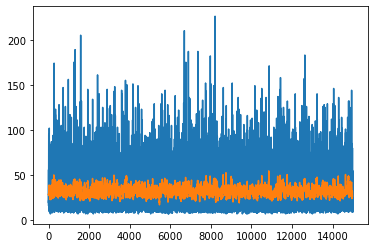

In [16]:
N = 20
plt.plot(range(len(episode_random_action_history)), episode_random_action_history)
plt.plot(np.convolve(np.array(episode_random_action_history), np.ones(N)/N, mode='valid'))

## Play the game with the trained agent

In [17]:
def play_game(env,max_steps_per_epoch = 10000,render = False):

    state = env.reset()
    episode_reward = 0
    
    done = False
    step_counter = 0

    while not done and step_counter < max_steps_per_epoch:
        
        step_counter += 1
        
        ###############################
        # Show
        
        if render: env.render()

        ###############################
        # Select Action

        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        # Take best action
        action = tf.argmax(action_probs[0]).numpy()

        ###############################
        # Act in the env

        state_next, reward, done, _ = env.step(action)

        ###############################
        # Store reward for that run

        episode_reward += reward    

        ###############################
        # Slow render

        if render: time.sleep(0.5)

        ###############################
        # Update state

        state = state_next


    return episode_reward

In [20]:
play_game(env=env,render=True)

-69